# TEXT MINING for PRACTICE
- 본 자료는 텍스트 마이닝을 활용한 연구 및 강의를 위한 목적으로 제작되었습니다.
- 본 자료를 강의 목적으로 활용하고자 하시는 경우 꼭 아래 메일주소로 연락주세요.
- 본 자료에 대한 허가되지 않은 배포를 금지합니다.
- 강의, 저작권, 출판, 특허, 공동저자에 관련해서는 문의 바랍니다.
- **Contact : ADMIN(admin@teanaps.com)**

---

In [1]:
# 텍스트 분석을 위한 TEANAPS 패키지를 설치합니다.
# TEANAPS는 Google Colaboratory/Linux 환경에 최적화되어 있습니다.
# Windows 환경에서 일부 기능에 제한이 있을 수 있습니다.

In [2]:
# TEANAPS (https://github.com/fingeredman/teanaps)
#!git clone https://github.com/fingeredman/teanaps.git

In [3]:
#!ls

In [4]:
#!python "teanaps/teanaps_setup.py"

## WEEK 11-1. 개봉전 영화리뷰로 총 관객수 예측하기
- Python으로 개봉전 영화리뷰를 활용해 총 관객수를 예측하는 방법에 대해 다룹니다.

---

### 1. 학습데이터 준비하기

---

#### 1.1. TEANAPS 라이브러리 불러오기

---

In [6]:
from teanaps.nlp import MorphologicalAnalyzer
from teanaps.nlp import Processing
from teanaps.handler import FileHandler
from teanaps.text_analysis import TfidfCalculator
from teanaps.visualization import GraphVisualizer

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

import numpy as np
import matplotlib.pyplot as plt
import datetime

from bs4 import BeautifulSoup 
import requests
import datetime

ma = MorphologicalAnalyzer()
ma.set_tagger("mecab")
tfidf = TfidfCalculator()
processing = Processing()
fh = FileHandler()
gv = GraphVisualizer()

#### 1.2. 데이터 파일 불러오기: 영화정보

---

In [7]:
movie_dict = {}

f = open("data/movie_list.txt", encoding="utf-8")
for line in f:
    line = line.strip()
    col = line.split("\t")
    movie_name = col[0]
    opening_date = col[1]
    viewer = int(col[2].strip().replace(",", "")) # "12186327"
    movie_code = col[3]
    movie_dict[movie_name] = {"viewer": np.sqrt(viewer), "opening_date": opening_date}
f.close()

In [8]:
movie_dict

{'택시운전사': {'viewer': 3490.8920063502396, 'opening_date': '20170802'},
 '공조': {'viewer': 2796.0003576537683, 'opening_date': '20170118'},
 '스파이더맨: 홈 커밍': {'viewer': 2694.193385783582, 'opening_date': '20170705'},
 '범죄도시': {'viewer': 2622.9451004548305, 'opening_date': '20171003'},
 '군함도': {'viewer': 2567.51845173506, 'opening_date': '20170726'},
 '청년경찰': {'viewer': 2377.660614974307, 'opening_date': '20170809'},
 '더 킹': {'viewer': 2306.012359030194, 'opening_date': '20170118'},
 '미녀와 야수': {'viewer': 2266.78803596631, 'opening_date': '20170316'},
 '킹스맨: 골든 서클': {'viewer': 2223.8444190185605, 'opening_date': '20170927'},
 '토르: 라그나로크': {'viewer': 2203.1291382939858, 'opening_date': '20171025'},
 '꾼': {'viewer': 2004.5036792183746, 'opening_date': '20171122'},
 '남한산성': {'viewer': 1961.9090192972762, 'opening_date': '20171003'},
 '미이라': {'viewer': 1920.7615677121405, 'opening_date': '20170606'},
 '분노의 질주: 더 익스트림': {'viewer': 1911.3445529260287, 'opening_date': '20170412'},
 '너의 이름은.': {'view

In [9]:
xy = []

for movie_name, movie_meta in movie_dict.items():
    xy.append([movie_name, movie_meta["viewer"]])
xy.sort(key=lambda elem: elem[1])

x = [x for x, _ in xy]
y = [y for _, y in xy]

data_meta_list = []

data_meta = {
    "graph_type": "scatter",
    "data_name": "Y",
    "x_data": x,
    "y_data": y,
    "y_axis": "y1",
}
data_meta_list.append(data_meta)

graph_meta = {
    "title": "영화 관객수",
    "x_tickangle": 45,
    "y1_tickangle": 0,
    "y2_tickangle": 0,
    "x_name": "영화명",
    "y1_name": "관람객수",
    "y2_name": "Y2",
}

gv.draw_line_graph(data_meta_list, graph_meta)

#### 1.3. 데이터 파일 불러오기: 영화리뷰

---

In [10]:
data = []
progress = 0

f = open("data/movie_comment_17-19_pre.txt", encoding="utf-8")
for line in f:
    progress += 1
    print(progress, end="\r")
    
    line = line.replace("\n", "")
    #print(line)
    col = line.split("\t")
    movie_name = col[0]
    date_time = col[1]
    #_date_time = datetime.datetime.strptime(date_time, "%Y.%m.%d %H:%M")
    opening_date = movie_dict[movie_name]["opening_date"]
    #opening_date = datetime.datetime.strptime(opening_date, "%Y%m%d")
    comment = col[2]
    # 개봉일 이전 리뷰만 필터링
    #print(_date_time, opening_date)
    #if _date_time <= opening_date + datetime.timedelta(days=3):
    data.append([movie_name, date_time, comment])
f.close()

1917

In [11]:
print(len(data))

684270


In [12]:
data[:3]

[['택시운전사',
  '2017.08.02 09:29',
  '송강호 유해진 류준열이 한번씩 눈물 쏟게 만듦.. 그날의 광주에 택시운전사와 함께 다녀온 듯 먹먹하다'],
 ['택시운전사', '2017.08.02 09:28', '최근에 본 영화중 가장 돈이 안 아까운 영화!'],
 ['택시운전사',
  '2017.08.02 09:24',
  '신파일까봐 걱정했는데 신파는 커녕 눈물이 날만하면 가차없이 유쾌함을 던져주던 담백한 영화,,덕분에 억지 눈물이 아닌 진짜 눈물만 나왔다']]

#### 1.4. 텍스트 데이터 임베딩: TF-IDF Matrix

---

In [19]:
movie_comment_dict = {}
POS_LIST = ["NNP", "NNG"]

index = 0
for movie_name, date_time, comment in data:
    index += 1
    print(index, end="\r")
    
    # 명사형 문장 만들기
    pos_result = ma.parse(comment)
    pos_sentence = processing.get_plain_text(pos_result, pos_list=POS_LIST, tag=False)
    # Feature로 활용할 단어개수를 100개로 한정
    #_pos_result = [(word, pos, loc) for word, pos, loc in pos_result if word in feature_list]
    #pos_sentence = processing.get_plain_text(_pos_result, pos_list=POS_LIST, tag=False)
    
    # 영화별 명사형 문장 Dictionary에 저장하기
    if movie_name in movie_comment_dict.keys():
        movie_comment_dict[movie_name] += " " + pos_sentence
    else:
        movie_comment_dict[movie_name] = pos_sentence

In [20]:
movie_comment_list = []
movie_viewer_list = []

for movie_name, pos_sentence_list in movie_comment_dict.items():
    movie_comment_list.append(pos_sentence_list)
    movie_viewer_list.append(movie_dict[movie_name]["viewer"])

In [21]:
len(movie_comment_list)

283

In [22]:
movie_comment_list[0][:200]

'류준열 눈물 영화 영화 눈물 영화 눈물 눈물 영화 배우 연기 역사 가슴 영화 눈물 눈물   영화 소재 마음 영화 영화 강추 이번 영화 마음 한국 영화 기대 여운 감동 웃음 연기 몰입 영화 영화 가슴 영화 류준열 연기 최고  재미 감동 영화 가족 강추  몰입 배우 류준열 영화 영화 역사 마음 영화 역사 영화  역사 영화 개봉 영상 추천 영화 영화 가슴 영화 '

In [17]:
# TF-IDF 계산
tfidf.calculation_tfidf(movie_comment_list, 
                        tf_vectorizer_path="data/tf_vectorizer", 
                        tfidf_vectorizer_path="data/tfidf_vectorizer")

In [18]:
# Feature로 활용할 단어개수를 100개로 한정하기 위한 리스트 생성
feature_list = [word for word, _ in tfidf.get_tfidf_list()[:100]]

# 여기까지 실행 후 주석처리하고 다시 1.4 과정으로 돌아가기

In [23]:
# TF-IDF 계산
tfidf.calculation_tfidf(movie_comment_list, 
                        tf_vectorizer_path="data/tf_vectorizer", 
                        tfidf_vectorizer_path="data/tfidf_vectorizer")
tfidf_matrix = tfidf.get_tfidf_matrix().values[:]

# 정답 label 불러오기
label_list = movie_viewer_list

# 학습데이터/평가데이터 분리
x_train, x_test, y_train, y_test = train_test_split(tfidf_matrix, label_list, test_size=0.20)

### 2. 학습하기

---

In [24]:
mlr_model = LinearRegression()
mlr_model.fit(x_train, y_train) 

# 학습모델 저장
fh.save_data("data/mlr_model", mlr_model)

In [25]:
y_predict = mlr_model.predict(x_train)

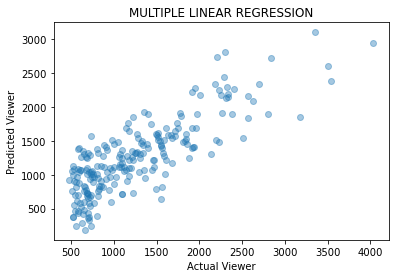

In [26]:
plt.scatter(y_train, y_predict, alpha=0.4)
plt.xlabel("Actual Viewer")
plt.ylabel("Predicted Viewer")
plt.title("MULTIPLE LINEAR REGRESSION")
plt.show()

In [27]:
y_predict = mlr_model.predict(x_test)

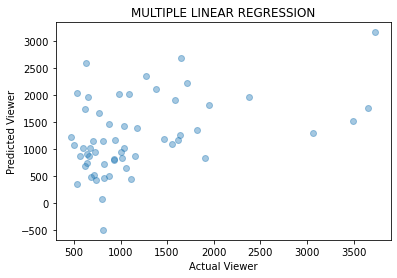

In [28]:
plt.scatter(y_test, y_predict, alpha=0.4)
plt.xlabel("Actual Viewer")
plt.ylabel("Predicted Viewer")
plt.title("MULTIPLE LINEAR REGRESSION")
plt.show()

### 3. R-Squared 평가하기

---

In [29]:
r_squared = mlr_model.score(x_train, y_train)
print("전체 영화 관객수 데이터의", r_squared, "를 설명 가능한 모델로 평가됨")

전체 영화 관객수 데이터의 0.6706859130284153 를 설명 가능한 모델로 평가됨


In [30]:
r_squared = mlr_model.score(x_test, y_test)
print("전체 영화 관객수 데이터의", r_squared, "를 설명 가능한 모델로 평가됨")

전체 영화 관객수 데이터의 -0.02168103236368335 를 설명 가능한 모델로 평가됨


In [31]:
y_predict = mlr_model.predict(x_train)
np.sqrt(mean_squared_error(y_train, y_predict))

380.99149814427415

In [32]:
y_predict = mlr_model.predict(x_test)
np.sqrt(mean_squared_error(y_test, y_predict))

771.2672574042907

### 4. 학습모델 활용하기

---

#### 4.1. 새로운 영화리뷰 수집하기

---

In [60]:
MOVIE_CODE = "76016"
#MOVIE_CODE = "73318"
#MOVIE_CODE = "130786"
TITLE = "써니"
#TITLE = "시라노 연애조작단"
#TITLE = "조선마술사"

SAVE_FILE_PATH = "data/movie_comment.txt"
f = open(SAVE_FILE_PATH, "w", encoding="utf-8")


# 전체 댓글개수 가져오기
URL = "https://movie.naver.com/movie/bi/mi/pointWriteFormList.nhn?code=" + MOVIE_CODE + "&type=after&isActualPointWriteExecute=false&isMileageSubscriptionAlready=false&isMileageSubscriptionReject=false&page=1"
response = requests.get(URL)
soup = BeautifulSoup(response.text, "html.parser")
comment_total = int(soup.find("strong", {'class': "total",}).find("em",).text.replace(",", ""))
page_limit = comment_total/10
if page_limit % 1 > 0:
    page_limit = int(page_limit) + 1
else:
    page_limit = int(page_limit)
# 댓글 가져오기
for page in range(1, page_limit+1):
    print(page, "/", page_limit, end="\r")
    URL = "https://movie.naver.com/movie/bi/mi/pointWriteFormList.nhn?code=" + MOVIE_CODE + "&type=after&isActualPointWriteExecute=false&isMileageSubscriptionAlready=false&isMileageSubscriptionReject=false&page="
    URL = URL + str(page)
    response = requests.get(URL)
    soup = BeautifulSoup(response.text, "html.parser")
    comment_list = soup.findAll("div", {'class': "score_reple",})
    for comment in comment_list:
        try:
            span_tag_list = comment.find("p").findAll("span")
            date_time = comment.findAll("em")[1].text
            if span_tag_list[0].text == "관람객":
                f.write(TITLE + "\t" + date_time + "\t" + span_tag_list[1].text.strip() + "\n")
            else:
                f.write(TITLE + "\t" + date_time + "\t" + span_tag_list[0].text.strip() + "\n")
        except:
            continue
    f.flush()
    
f.close()

#### 4.2. 개봉일 이후 3개월 리뷰만 필터링하기

---

In [61]:
opening_date = "20110504" # 써니
#opening_date = "20100916" # 시라노 연애조작단
#opening_date = "20151230" # 조선마술사

sample_data = []
progress = 0

f = open("data/movie_comment.txt", encoding="utf-8")
for line in f:
    progress += 1
    print(progress, end="\r")
    
    line = line.replace("\n", "")
    #print(line)
    col = line.split("\t")
    try:
        movie_name = col[0]
        date_time = col[1]
        _date_time = datetime.datetime.strptime(date_time, "%Y.%m.%d %H:%M")
        opening_datetime = datetime.datetime.strptime(opening_date, "%Y%m%d")
        comment = col[2]
        # 개봉일 이전 리뷰만 필터링
        #print(_date_time, opening_date)
        if _date_time <= opening_datetime + datetime.timedelta(days=3):
            sample_data.append([movie_name, date_time, comment])
    except:
        continue
f.close()

In [62]:
len(sample_data)

1402

In [63]:
sample_data[:3]

[['써니', '2011.05.06 23:56', '어떤 면에서도 빠지지 않는 영화! 정말 내생의 최고의 영화~~ 연기가 대박'],
 ['써니', '2011.05.06 23:56', '감동이나 공감은 별론데, 소소한 웃음코드들이 좋았다'],
 ['써니', '2011.05.06 23:53', '정말 최고의 영화 말이 필요없음 ㅋㅋㅋㅋㅋ']]

In [64]:
pos_sentence = ""

for movie_name, date_time, comment in sample_data:
    pos_result = ma.parse(comment)
    _pos_result = [(word, pos, loc) for word, pos, loc in pos_result if word in feature_list]
    pos_sentence += " " + processing.get_plain_text(_pos_result, pos_list=POS_LIST, tag=False)

In [65]:
pos_sentence[:200]

' 영화 최고 영화 연기 대박 감동 웃음 최고 영화 필요 영화 연기 재미 대박 필요 영화 마지막 웃음 감동 시간 친구 영화 강추 추천 영화  감독 최고 대박 영화관 영화 처음 필요 대박  친구 영화 친구 대박 필요 감독 최고 감동 감동 영화 대박 연기 영화 자체 감동 내용 영화 영화 영화  기대 대박 영화 평점 오랜만 영화 대박 영화 친구 대박 친구  영화 '

In [66]:
input_vector = tfidf.get_tfidf_vector(pos_sentence, tfidf_vectorizer_path="data/tfidf_vectorizer")
# 학습모델 불러오기
model = fh.load_data("data/mlr_model")
# 분류수행
predict = int(model.predict([input_vector]).tolist()[0])
predict

2225

In [67]:
#써니 : 7,362,467
predict = model.predict([input_vector]).tolist()[0]
predict*predict

4952535.000991828

In [49]:
#시라노연애조작단 : 2,731,828
predict = model.predict([input_vector]).tolist()[0]
predict*predict

5199828.279651097

In [58]:
#조선마술사 : 628,576
predict = model.predict([input_vector]).tolist()[0]
predict*predict

884315.8998472079

    - 영화관객수 확인 링크
> http://www.kobis.or.kr/kobis/business/main/main.do